In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import requests
import datetime
from matplotlib.lines import Line2D
import matplotlib as mpl
import copy
import math

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

In [3]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*5)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-12-01
2027-11-30


In [4]:
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [5]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

In [6]:
def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, cil_qap, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    
    # compute ROI based on QAP
    cil_qap['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_qap['day_locked_pledge']-cil_qap['day_renewed_pledge'])/(cil_qap['day_onboarded_power_QAP'])
    cil_qap['day_rewards_per_sector'] = SECTOR_SIZE * cil_qap.day_network_reward / cil_qap.network_QAP
    cil_qap['1y_return_per_sector'] = cil_qap['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_qap['1y_sector_roi'] = cil_qap['1y_return_per_sector'] / cil_qap['day_pledge_per_QAP']
    
    # understand delta between RBP and QAP
    def get_delta(key):
        return cil_qap[key] - cil_rbp[key]
    
    delta_df = pd.DataFrame()
    delta_df['date'] = cil_rbp['date']
    delta_df['network_baseline'] = cil_rbp['network_baseline']
    delta_df['network_RBP'] = cil_rbp['network_RBP']
    delta_df['network_QAP'] = cil_rbp['network_QAP']
    
    delta_df['network_locked'] = get_delta('network_locked')
    delta_df['circ_supply'] = get_delta('circ_supply')
    delta_df['circ_supply_pct'] = delta_df['circ_supply']/cil_rbp['circ_supply']
    delta_df['locked_over_supply'] = (cil_qap['network_locked']/cil_qap['circ_supply']) - (cil_rbp['network_locked']/cil_rbp['circ_supply'])
    delta_df['day_locked_pledge'] = get_delta('day_locked_pledge')
    
    delta_df['day_pledge_per_QAP'] = get_delta('day_pledge_per_QAP')    
    delta_df['day_pledge_per_QAP_pctincr'] = get_delta('day_pledge_per_QAP')/cil_rbp['day_pledge_per_QAP'] * 100
    delta_df['day_rewards_per_sector'] = get_delta('day_rewards_per_sector')
    delta_df['1y_return_per_sector'] = get_delta('1y_return_per_sector')
    delta_df['1y_sector_roi'] = get_delta('1y_sector_roi')

    delta_df['capped_power'] = get_delta('capped_power')
    delta_df['network_time'] = get_delta('network_time')
    delta_df['cum_baseline_reward'] = get_delta('cum_baseline_reward')
    delta_df['day_network_reward'] = get_delta('day_network_reward')
    delta_df['day_network_reward_pctincr'] = get_delta('day_network_reward')/cil_rbp['day_network_reward'] * 100
    
    delta_df['network_RBP'] = cil_rbp['network_RBP']
    delta_df['network_QAP'] = cil_rbp['network_QAP']
    
    return cil_rbp, cil_qap, delta_df

def run_sim(rb_onboard_power_pred, renewal_rate_vec_pred, fil_plus_rate_pred,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={}):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred])    

    res = get_sector_expiration_stats(start_date, current_date,end_date)
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec[-int(forecast_lenght):],
        fil_plus_rate_pred,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
    
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    mint_df_qapbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'qap'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec
    )
    cil_df_qap = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df_qapbase,
        known_scheduled_pledge_release_full_vec
    )
    
    # we set duration=365 here to annualize it
    rbp_roi, qap_roi, delta_roi = add_generated_quantities(cil_df_rbp, cil_df_qap, duration=365)
    
    return_dict = {
        'rbp_roi': rbp_roi,
        'qap_roi': qap_roi,
        'delta_roi': delta_roi,
        'renewal_rate_vec': renewal_rate_vec,
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'fil_plus_rate_pred': fil_plus_rate_pred
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [7]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - datetime.timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 500
seasonality_mcmc = 2000
num_chains_mcmc = 2

rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
    generate_mcmc_forecast_samples(mcmc_train_start_date,
                                   mcmc_train_end_date,
                                   forecast_lenght,
                                   num_warmup_mcmc,
                                   num_samples_mcmc,
                                   seasonality_mcmc,
                                   num_chains_mcmc)

Forecasting Onboarding Power


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.11      0.09     -0.08     -0.24     -0.00    305.81      1.00
       init_s[0]    -20.61    305.29     -0.38    -44.48     50.19    180.48      1.00
       init_s[1]     -0.20      0.54     -0.22     -0.94      0.72    386.98      1.00
       init_s[2]      1.48      0.64      1.46      0.48      2.37    303.60      1.00
       init_s[3]      0.42      0.70      0.42     -0.72      1.49    213.32      1.02
       init_s[4]      0.00      0.75      0.01     -1.00      1.32    206.81      1.01
       init_s[5]      0.33      0.81      0.31     -1.02      1.55    201.24      1.01
       init_s[6]     -0.27      0.86     -0.30     -1.65      1.04    118.30      1.02
       init_s[7]     -0.62      0.93     -0.63     -2.09      0.91    159.41      1.01
       init_s[8]     -1.01      0.99     -1.02     -2.52      0.62    106.43      1.03
       init_s[9]     -0.39      1.00     -

Forecasting Renewal Rate


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.53      0.43      0.41      0.01      1.14    114.30      1.04
       init_s[0]      1.53     41.01      0.05    -19.39     15.85    520.32      1.00
       init_s[1]     -2.71      0.85     -2.76     -3.98     -1.22    600.41      1.00
       init_s[2]     -0.19      0.88     -0.20     -1.74      1.18    723.08      1.00
       init_s[3]      0.44      0.93      0.45     -1.02      1.79    539.34      1.00
       init_s[4]      8.85      1.05      8.84      7.10     10.38    503.97      1.00
       init_s[5]      1.52      1.00      1.52      0.03      3.24    283.74      1.01
       init_s[6]      0.28      1.08      0.28     -1.24      2.22    241.43      1.00
       init_s[7]     -0.69      1.06     -0.68     -2.22      1.25    309.38      1.00
       init_s[8]      4.05      1.16      4.06      2.28      5.87    346.49      1.00
       init_s[9]     -0.22      1.07     -

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.23      0.21      0.18     -0.01      0.54    102.74      1.03
       init_s[0]     -0.47     17.80     -0.01    -12.04     10.98    742.83      1.00
       init_s[1]      1.00      0.61      0.98      0.03      1.96    721.47      1.00
       init_s[2]      1.21      0.68      1.22      0.17      2.29    603.15      1.00
       init_s[3]      8.59      0.84      8.55      7.30      9.82    619.44      1.00
       init_s[4]     -0.37      0.75     -0.42     -1.44      0.83    532.56      1.00
       init_s[5]      0.22      0.78      0.17     -0.98      1.50    425.87      1.00
       init_s[6]     -0.16      0.78     -0.19     -1.44      0.97    375.75      1.00
       init_s[7]      9.51      0.90      9.48      8.05     10.79    411.18      1.00
       init_s[8]     -0.06      0.82     -0.08     -1.29      1.23    391.30      1.00
       init_s[9]     -0.40      0.73     -

Forecasting FIL+ Rate


  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend      0.02      0.02      0.02      0.00      0.06      4.70      1.63
       init_s[0]     -0.00      1.11      0.03     -0.95      0.91    306.86      1.02
       init_s[1]      0.05      0.08      0.06     -0.07      0.16     61.04      1.04
       init_s[2]     -0.01      0.08     -0.01     -0.13      0.13    610.19      1.00
       init_s[3]      0.00      0.10      0.00     -0.16      0.15    241.87      1.01
       init_s[4]      0.13      0.11      0.14     -0.04      0.30     24.03      1.07
       init_s[5]      0.07      0.13      0.07     -0.16      0.25     13.14      1.12
       init_s[6]      0.12      0.12      0.10     -0.07      0.33    137.88      1.02
       init_s[7]      0.13      0.13      0.14     -0.07      0.33     15.56      1.08
       init_s[8]      0.20      0.14      0.20     -0.01      0.43     13.87      1.11
       init_s[9]      0.28      0.13      

  0%|          | 0/5500 [00:00<?, ?it/s]

  0%|          | 0/5500 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend     -0.13      0.11     -0.10     -0.28     -0.01    296.43      1.00
       init_s[0]      1.87     50.03      0.51    -43.06     39.93    670.41      1.00
       init_s[1]     -0.24      0.63     -0.25     -1.26      0.78    508.63      1.00
       init_s[2]      1.49      0.72      1.50      0.24      2.52    502.07      1.00
       init_s[3]      0.45      0.81      0.46     -0.99      1.60    433.19      1.00
       init_s[4]     -0.12      0.87     -0.11     -1.50      1.21    470.17      1.00
       init_s[5]      0.22      0.94      0.25     -1.24      1.72    363.45      1.00
       init_s[6]     -0.44      0.98     -0.41     -1.88      1.26    316.85      1.00
       init_s[7]     -0.76      0.98     -0.70     -2.30      0.88    271.17      1.00
       init_s[8]     -1.21      1.03     -1.19     -2.93      0.36    246.31      1.00
       init_s[9]     -0.65      1.08     -

In [22]:
pct_max = 0.7
target = 180
intervention_date=datetime.date(2023,3,15)
duration_1y=365
duration_3y=365*3
duration_5y=365*5
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
# duration_m = lambda d: d/365.

smooth_scenario = curated.forecast_smooth_scenario(forecast_lenght,
                                                   pct_max,
                                                   target,
                                                   rb_onboard_setting = 'smooth_pcttarget',
                                                   renewal_rate_setting = 'smooth_pcttarget',
                                                   filplus_rate_setting = 'historical_median',
                                                   start_date=today)
mcmc_scenario = {
    'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
}

sim_vec = [
    {'name': 'No-SDM', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_1y, 'duration_m': lambda d: 1, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': False,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    },
    {'name': '1A(3Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_3y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    },
    {'name': '1B(3Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_3y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'cc_early_renewal',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    },
    {'name': '2A(3Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_3y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    },
    {'name': '2B(3Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_3y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'cc_early_terminate_and_onboard',
                   'cc_reonboard_time_days': 60,
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    },
    
    {'name': '1A(5Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_5y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    },
    {'name': '1B(5Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_5y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'cc_early_renewal',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': True
               }
              }
    },
    {'name': '2A(5Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_5y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    },
    {'name': '2B(5Y)', 'sim_inputs': mcmc_scenario,
     'kwargs':{'duration': duration_5y, 'duration_m': duration_m, 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'cc_early_terminate_and_onboard',
                   'cc_reonboard_time_days': 60,
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_onboard_before_intervention': False,
                   'sdm_onboard_after_intervention': True,
                   'sdm_renew_before_intervention': False,
                   'sdm_renew_after_intervention': False
               }
              }
    }
]

In [23]:
duration_loop_results = {}
for sim in tqdm(sim_vec):
    sim_inputs = sim['sim_inputs']
    kwargs = sim['kwargs']
    return_dict = run_sim(sim_inputs['rb_onboard_power'], sim_inputs['renewal_rate'], sim_inputs['filplus_rate'],
                          **kwargs)
    duration_loop_results[sim['name']] = return_dict

  0%|          | 0/9 [00:00<?, ?it/s]

895.6893174497168
693.4476040402687
693.4476040402687
693.4476040402687
693.4476040402687
693.4476040402687
693.4476040402687
693.4476040402687
693.4476040402687


<IPython.core.display.Javascript object>


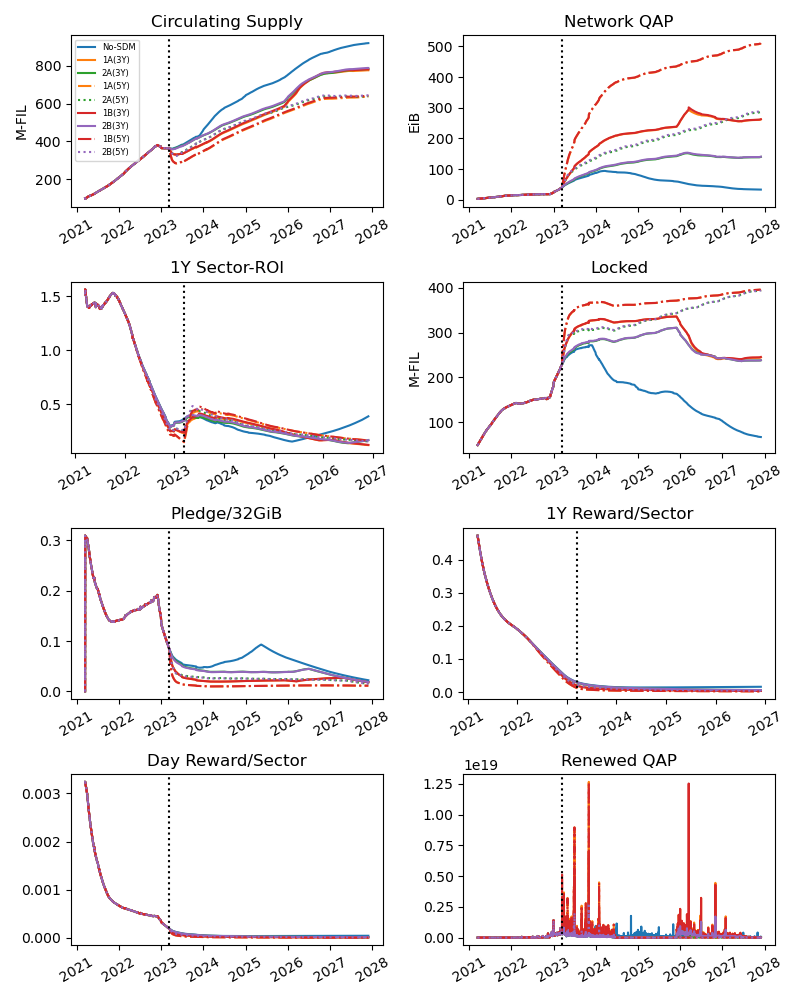

In [24]:
plt_sdm = True
plt_a = True
plt_b = True
plt_3y = True
plt_5y = True

plt.figure(figsize=(8,10))
if plt_sdm:
    no_sdm = duration_loop_results['No-SDM']['rbp_roi']
if plt_a:
    if plt_3y:
        r1a_3y = duration_loop_results['1A(3Y)']['rbp_roi']
        r2a_3y = duration_loop_results['2A(3Y)']['rbp_roi']
    if plt_5y:
        r1a_5y = duration_loop_results['1A(5Y)']['rbp_roi']
        r2a_5y = duration_loop_results['2A(5Y)']['rbp_roi']
if plt_b:
    if plt_3y:
        r1b_3y = duration_loop_results['1B(3Y)']['rbp_roi']
        r2b_3y = duration_loop_results['2B(3Y)']['rbp_roi']
    if plt_5y:
        r1b_5y = duration_loop_results['1B(5Y)']['rbp_roi']
        r2b_5y = duration_loop_results['2B(5Y)']['rbp_roi']

plt.subplot(4,2,1)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['circ_supply'] / MEGA, label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['circ_supply'] / MEGA, label='1A(3Y)')
        p2 = plt.plot(r2a_3y['date'], r2a_3y['circ_supply'] / MEGA, label='2A(3Y)')
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['circ_supply'] / MEGA, color=p1[0].get_color(), linestyle='-.', label='1A(5Y)')
        plt.plot(r2a_5y['date'], r2a_5y['circ_supply'] / MEGA, color=p2[0].get_color(), linestyle=':', label='2A(5Y)')
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['circ_supply'] / MEGA, label='1B(3Y)')
        p2 = plt.plot(r2b_3y['date'], r2b_3y['circ_supply'] / MEGA, label='2B(3Y)')
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['circ_supply'] / MEGA, color=p1[0].get_color(), linestyle='-.', label='1B(5Y)')
        plt.plot(r2b_5y['date'], r2b_5y['circ_supply'] / MEGA, color=p2[0].get_color(), linestyle=':', label='2B(5Y)')
plt.axvline(intervention_date, linestyle=':', color='k') #, label='Intervention Date')

plt.ylabel('M-FIL')
plt.title('Circulating Supply')
plt.legend(fontsize=6)
plt.xticks(rotation=30)

plt.subplot(4,2,2)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['network_QAP'] / EIB, label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['network_QAP']/EIB, label='1A(3Y)')
        p2 = plt.plot(r2a_3y['date'], r2a_3y['network_QAP']/EIB, label='2A(3Y)')
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['network_QAP']/EIB, color=p1[0].get_color(), linestyle='-.', label='1A')
        plt.plot(r2a_5y['date'], r2a_5y['network_QAP']/EIB, color=p2[0].get_color(), linestyle=':', label='2A')
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['network_QAP']/EIB, label='1B(3Y)')
        p2 = plt.plot(r2b_3y['date'], r2b_3y['network_QAP']/EIB, label='2B(3Y)')
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['network_QAP']/EIB, color=p1[0].get_color(), linestyle='-.', label='1B')
        plt.plot(r2b_5y['date'], r2b_5y['network_QAP']/EIB, color=p2[0].get_color(), linestyle=':', label='2B')
plt.axvline(intervention_date, linestyle=':', color='k') #, label='Intervention Date')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
plt.xticks(rotation=30)

plt.subplot(4,2,3)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['1y_sector_roi'], label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['1y_sector_roi'], label='1A(3Y)')
        p2 = plt.plot(r2a_3y['date'], r2a_3y['1y_sector_roi'], label='2A(3Y)')
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['1y_sector_roi'], color=p1[0].get_color(), linestyle='-.', label='1A')
        plt.plot(r2a_5y['date'], r2a_5y['1y_sector_roi'], color=p2[0].get_color(), linestyle=':', label='2A')
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['1y_sector_roi'], label='1B(3Y)')
        p2 = plt.plot(r2b_3y['date'], r2b_3y['1y_sector_roi'], label='2B(3Y)')
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['1y_sector_roi'], color=p1[0].get_color(), linestyle='-.', label='1B')
        plt.plot(r2b_5y['date'], r2b_5y['1y_sector_roi'], color=p2[0].get_color(), linestyle=':', label='2B')
plt.axvline(intervention_date, linestyle=':', color='k') #, label='Intervention Date')
plt.title('1Y Sector-ROI')
plt.xticks(rotation=30)

plt.subplot(4,2,4)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['network_locked']/MEGA, label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['network_locked']/MEGA)
        p2 = plt.plot(r2a_3y['date'], r2a_3y['network_locked']/MEGA)
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['network_locked']/MEGA, color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2a_5y['date'], r2a_5y['network_locked']/MEGA, color=p2[0].get_color(), linestyle=':', )
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['network_locked']/MEGA)
        p2 = plt.plot(r2b_3y['date'], r2b_3y['network_locked']/MEGA)
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['network_locked']/MEGA, color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2b_5y['date'], r2b_5y['network_locked']/MEGA, color=p2[0].get_color(), linestyle=':', )
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('Locked')
plt.ylabel('M-FIL')
plt.xticks(rotation=30)
# plt.subplot(4,2,4)
# plt.plot(no_sdm['date'], no_sdm['day_locked_pledge'], label='No-SDM')
# plt.plot(r1a['date'], r1a['day_locked_pledge'])
# # plt.plot(r1b['date'], r1b['day_locked_pledge'])
# plt.plot(r2a['date'], r2a['day_locked_pledge'])
# # plt.plot(r2b['date'], r2b['day_locked_pledge'])
# plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
# plt.title('Day Locked')
# plt.xticks(rotation=30)


plt.subplot(4,2,5)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['day_pledge_per_QAP'], label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['day_pledge_per_QAP'])
        p2 = plt.plot(r2a_3y['date'], r2a_3y['day_pledge_per_QAP'])
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['day_pledge_per_QAP'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2a_5y['date'], r2a_5y['day_pledge_per_QAP'], color=p2[0].get_color(), linestyle=':', )
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['day_pledge_per_QAP'])
        p2 = plt.plot(r2b_3y['date'], r2b_3y['day_pledge_per_QAP'])
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['day_pledge_per_QAP'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2b_5y['date'], r2b_5y['day_pledge_per_QAP'], color=p2[0].get_color(), linestyle=':', )
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('Pledge/32GiB')
plt.xticks(rotation=30)

plt.subplot(4,2,6)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['1y_return_per_sector'], label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['1y_return_per_sector'])
        p2 = plt.plot(r2a_3y['date'], r2a_3y['1y_return_per_sector'])
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['1y_return_per_sector'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2a_5y['date'], r2a_5y['1y_return_per_sector'], color=p2[0].get_color(), linestyle=':', )
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['1y_return_per_sector'])
        p2 = plt.plot(r2b_3y['date'], r2b_3y['1y_return_per_sector'])
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['1y_return_per_sector'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2b_5y['date'], r2b_5y['1y_return_per_sector'], color=p2[0].get_color(), linestyle=':', )
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('1Y Reward/Sector')
plt.xticks(rotation=30)

plt.subplot(4,2,7)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['day_rewards_per_sector'], label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['day_rewards_per_sector'])
        p2 = plt.plot(r2a_3y['date'], r2a_3y['day_rewards_per_sector'])
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['day_rewards_per_sector'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2a_5y['date'], r2a_5y['day_rewards_per_sector'], color=p2[0].get_color(), linestyle=':', )
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['day_rewards_per_sector'])
        p2 = plt.plot(r2b_3y['date'], r2b_3y['day_rewards_per_sector'])
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['day_rewards_per_sector'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2b_5y['date'], r2b_5y['day_rewards_per_sector'], color=p2[0].get_color(), linestyle=':', )
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('Day Reward/Sector')
plt.xticks(rotation=30)
# plt.plot(no_sdm['date'], no_sdm['day_renewed_pledge'], label='No-SDM')
# plt.plot(r1a['date'], r1a['day_renewed_pledge'])
# # plt.plot(r1b['date'], r1b['day_renewed_pledge'])
# plt.plot(r2a['date'], r2a['day_renewed_pledge'])
# # plt.plot(r2b['date'], r2b['day_renewed_pledge'])
# plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
# plt.title('Day Renewed')
# plt.xticks(rotation=30)

plt.subplot(4,2,8)
if plt_sdm:
    plt.plot(no_sdm['date'], no_sdm['day_renewed_power_QAP'], label='No-SDM')
if plt_a:
    if plt_3y:
        p1 = plt.plot(r1a_3y['date'], r1a_3y['day_renewed_power_QAP'])
        p2 = plt.plot(r2a_3y['date'], r2a_3y['day_renewed_power_QAP'])
    if plt_5y:
        plt.plot(r1a_5y['date'], r1a_5y['day_renewed_power_QAP'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2a_5y['date'], r2a_5y['day_renewed_power_QAP'], color=p2[0].get_color(), linestyle=':', )
if plt_b:
    if plt_3y:
        p1 = plt.plot(r1b_3y['date'], r1b_3y['day_renewed_power_QAP'])
        p2 = plt.plot(r2b_3y['date'], r2b_3y['day_renewed_power_QAP'])
    if plt_5y:
        plt.plot(r1b_5y['date'], r1b_5y['day_renewed_power_QAP'], color=p1[0].get_color(), linestyle='-.', )
        plt.plot(r2b_5y['date'], r2b_5y['day_renewed_power_QAP'], color=p2[0].get_color(), linestyle=':', )
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('Renewed QAP')
plt.xticks(rotation=30)


# plt.subplot(4,2,8)
# # plt.plot(no_sdm['date'], no_sdm['day_onboarded_power_QAP'], label='No-SDM')
# # plt.plot(r1a['date'], r1a['day_onboarded_power_QAP'])
# # plt.plot(r1b['date'], r1b['day_renewed_power_QAP'])
# # plt.plot(r2a['date'], r2a['day_onboarded_power_QAP'])
# plt.plot(r2b['date'], r1b['day_renewed_power_QAP']-r2b['day_renewed_power_QAP'])
# plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
# plt.title('Renewed QAP')
# plt.xticks(rotation=30)


# cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP']

plt.tight_layout()
plt.savefig('/Users/kiran/Documents/sdm_take2/scenarios.png')

In [25]:
no_sdm.to_csv('/Users/kiran/Documents/sdm_take2/no_sdm.csv', index=False)
r1a_3y.to_csv('/Users/kiran/Documents/sdm_take2/1a_3y.csv', index=False)
r1b_3y.to_csv('/Users/kiran/Documents/sdm_take2/1b_3y.csv', index=False)
r2a_3y.to_csv('/Users/kiran/Documents/sdm_take2/2a_3y.csv', index=False)
r2b_3y.to_csv('/Users/kiran/Documents/sdm_take2/2b_3y.csv', index=False)
r1a_5y.to_csv('/Users/kiran/Documents/sdm_take2/1a_5y.csv', index=False)
r1b_5y.to_csv('/Users/kiran/Documents/sdm_take2/1b_5y.csv', index=False)
r2a_5y.to_csv('/Users/kiran/Documents/sdm_take2/2a_5y.csv', index=False)
r2b_5y.to_csv('/Users/kiran/Documents/sdm_take2/2b_5y.csv', index=False)

In [12]:
res = get_sector_expiration_stats(start_date, current_date,end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]

<IPython.core.display.Javascript object>


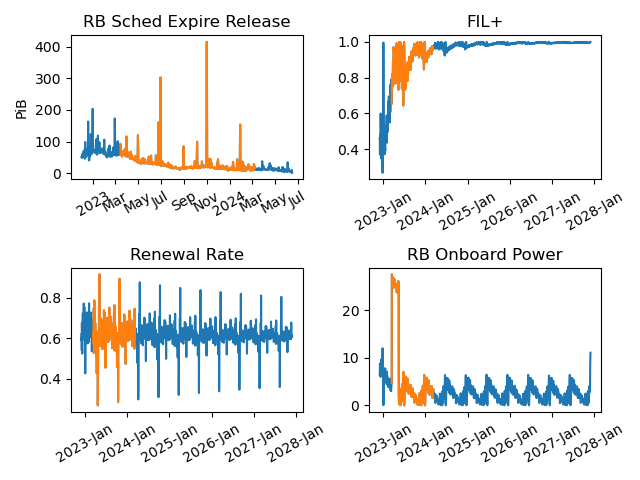

In [29]:
import matplotlib.dates as mdates

t_release_vec = [current_date + datetime.timedelta(days=x) for x in range(len(rb_known_scheduled_expire_vec))]
t_release_vec = np.asarray(t_release_vec)

ii_intervention_start = (intervention_date - current_date).days
ii_intervention_vec_schedrelease = np.asarray([ii_intervention_start + x for x in range(360)])

plt.figure()

plt.subplot(2,2,1)
plt.plot(t_release_vec, rb_known_scheduled_expire_vec)
plt.plot(t_release_vec[ii_intervention_vec_schedrelease], rb_known_scheduled_expire_vec[ii_intervention_vec_schedrelease])
# plt.plot(t_release_vec[ii_intervention_vec_schedrelease], qa_known_scheduled_expire_vec[ii_intervention_vec_schedrelease])
# plt.plot(t_release_vec[ii_intervention_vec_schedrelease], 
#          qa_known_scheduled_expire_vec[ii_intervention_vec_schedrelease]-rb_known_scheduled_expire_vec[ii_intervention_vec_schedrelease])
plt.ylabel('PiB')
plt.title('RB Sched Expire Release')
ax = plt.gca()
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=30)

t_input = np.asarray([today + datetime.timedelta(days=x) for x in range(forecast_lenght)])
ii_intervention_start = (intervention_date - today).days
ii_intervention_vec_inputs = np.asarray([ii_intervention_start + x for x in range(360)])

plt.subplot(2,2,2)
plt.plot(t_input, mcmc_scenario['filplus_rate'])
plt.plot(t_input[ii_intervention_vec_inputs], mcmc_scenario['filplus_rate'][ii_intervention_vec_inputs])
plt.title('FIL+')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=30)

plt.subplot(2,2,3)
plt.plot(t_input, mcmc_scenario['renewal_rate'])
plt.plot(t_input[ii_intervention_vec_inputs], mcmc_scenario['renewal_rate'][ii_intervention_vec_inputs])
plt.title('Renewal Rate')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=30)

plt.subplot(2,2,4)
plt.plot(t_input, mcmc_scenario['rb_onboard_power'])
plt.plot(t_input[ii_intervention_vec_inputs], mcmc_scenario['rb_onboard_power'][ii_intervention_vec_inputs])
plt.title('RB Onboard Power')
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.xticks(rotation=30)


plt.tight_layout()
plt.savefig('/Users/kiran/Documents/sdm_take2/inputs.png')